In [1]:
from __future__ import print_function, division

In [38]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import timeit
#from sklearn.cross_validation import train_test_split

In [48]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix

# Build Models from icd9-code features created using Likelihood model


**data tables** : new_alive, new_icd9


\\[\frac{P(death | icd9 =x) }{P(survival | icd9 =x)} = prior* \frac{ P(icd9 = x | death) }{P(icd9 = x | survival)} \\]

\\[  = prior* \frac{ \frac{count Deaths}{All Deaths}} {\frac{count Survival}{All Survival}} \\]



In [4]:
df = pd.read_csv('mimic_data/data_model1.csv')

In [5]:
df[:3]

,hadm_id,subject_id,expire_flag,gender,admission_type,diagnosis,age,07031,07041,1481,...,85205,85225,9878,99685,99688,E9278,V1062,V143,V4578,V568
0,121205,91,1,F,EMERGENCY,FEVER,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,183686,94,1,M,EMERGENCY,SEPSIS,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140037,94,1,M,EMERGENCY,PNEUMONIA,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.admission_type.unique()

array(['EMERGENCY', 'ELECTIVE', 'URGENT', 'NEWBORN'], dtype=object)

In [7]:
# ############ Admission_type into categorical 
cols = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums = [0, 1, 2, 3 ]
print(df.admission_type.unique())

df.admission_type.replace(cols, nums, inplace=True)

['EMERGENCY' 'ELECTIVE' 'URGENT' 'NEWBORN']


In [8]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
df.gender.replace(gen, n_g, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 54 columns):
hadm_id           58976 non-null int64
subject_id        58976 non-null int64
expire_flag       58976 non-null int64
gender            58976 non-null int64
admission_type    58976 non-null int64
diagnosis         58951 non-null object
age               58976 non-null float64
07031             58973 non-null float64
07041             58973 non-null float64
1481              58973 non-null float64
1519              58973 non-null float64
1530              58973 non-null float64
1560              58973 non-null float64
1715              58973 non-null float64
1910              58973 non-null float64
1965              58973 non-null float64
1971              58973 non-null float64
1972              58973 non-null float64
1984              58973 non-null float64
20030             58973 non-null float64
20510             58973 non-null float64
2468              58973 non-null float64


In [10]:
df.dropna(inplace=True)

In [24]:
"""
    build pr-curve comparing ground truth with model score
    truthvec - truth vectore
    scorevec - score vector
    s - type of classifier , eg. 'logistic', 'random forest' etc.
"""

def pr_curve(truthvec, scorevec, s, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)

    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec, label=s)
    plt.axis([0, 1, 0, 1])
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.legend()
    return (recallvec, precisionvec, threshvec)

In [49]:
# exclude diagnosis from the fit
df.columns.values
cols = ['gender', 'admission_type',
       'age', '07031', '07041', '1481', '1519', '1530',
       '1560', '1715', '1910', '1965', '1971', '1972', '1984', '20030',
       '20510', '2468', '25023', '27953', '29389', '3581', '36001',
       '36019', '36400', '3643', '3693', '37239', '37900', '4449', '46611',
       '485', '48801', '51181', '5581', '58281', '6829', '72290', '73004',
       '78939', '85205', '85225', '9878', '99685', '99688', 'E9278',
       'V1062', 'V143', 'V4578', 'V568'] # 'hadm_id', 'subject_id', 'expire_flag','diagnosis'

X = df.loc[:, cols]
y = df.loc[:,'expire_flag']

# Logistic Model: Gender, Age, Admission type + ICD9 codes

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [51]:
"""
    make an instance of a Logistic Regression Model 
"""

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
y_pred_lr = lr_model.fit(X_train, y_train).predict_proba(X_test)

In [53]:
lr_vec = y_pred_lr[:,1]

### Evaluation

In [19]:
"""
    ValueError: Can't handle mix of binary and continuous-multioutput
"""
#accuracy_score(y_test, y_pred_lr, normalize=True)

"\n    ValueError: Can't handle mix of binary and continuous-multioutput\n"

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,lr_vec)


0.7851114114741289

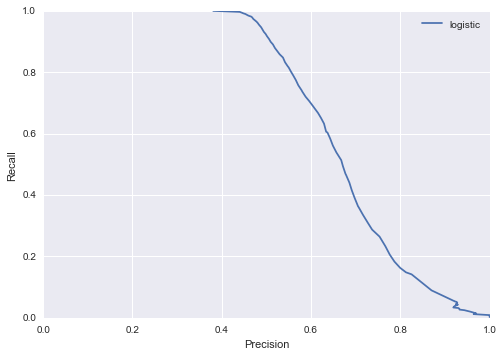

In [32]:
pr_curve(y_test, lr_vec,'logistic');

### Confusion matrix 

In [72]:
# for confusion matrix use method .predict, to get the predicted label, not probability
prediction = lr_model.fit(X_train, y_train).predict(X_test)
accuracy = accuracy_score(y_test, prediction, normalize=True)

In [62]:
prediction

array([1, 0, 0, ..., 0, 0, 0])

In [69]:
prediction.size

17685

In [66]:
y_test[:3]

13208    1
24071    0
47387    0
Name: expire_flag, dtype: int64

In [68]:
#imported above
cm = confusion_matrix(y_test, prediction)
cm

array([[8759, 2189],
       [2799, 3938]])

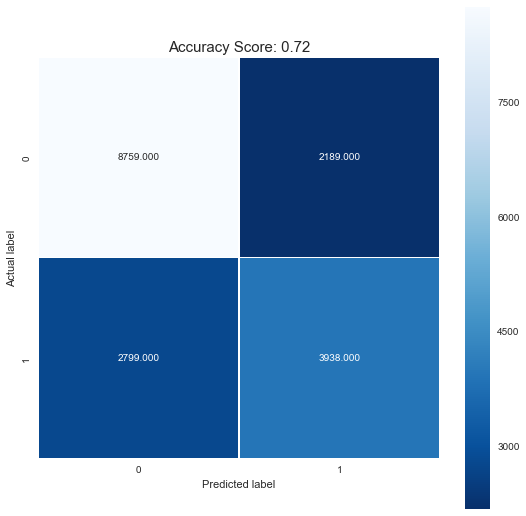

In [74]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(accuracy,2))
plt.title(all_sample_title, size = 15);

Model performs best in the accuracy of true positives, followed by true negatives

Model has somewhat higher number of false negatives (than false positives) 

Model under-estimates and mis-classifies fatal cases at higher rates than non-fatal. 

In [34]:
#random forest
plt.figure()
pr_curve(y_test, rf1_pred_vec,'random forest')
pr_curve(y_test, lr_vec,'logistic regression')
gb1_pr=pr_curve(y_test,gb1_pred_vec, 'gradient boost')
#plt.savefig('pr');

In [ ]:
#################
### for predict_proba, use log-loss

# for col in X_train.columns:
#     print (col)
#     X_tr = X_train.loc[:, col].values.reshape(-1,1)
#     X_te = X_test.loc[:,col].values.reshape(-1,1)
#     lr_model = LogisticRegression()
#     lr_model.fit(X_tr, y_train)
#     y_prob_pred = lr_model.predict_proba(X_te)[:,1]
#     print( "log-loss",log_loss(y_test, y_prob_pred)) 

# Random forest + gradient boosting


In [35]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss


In [ ]:
"""
    train Classifiers first: y_pred_RF
"""
# print("accuracy \t",accuracy_score(y_test, y_pred_RF, normalize=True))
# print ("precision \t ", precision_score(y_test, y_pred_RF))
# print ("recall \t", recall_score(y_test, y_pred_RF))
# print ('f1 \t',f1_score(y_test, y_pred_RF))

Notes
+ recall is improved when max_features is increased
+ n_estimators : does not seem to have an affect


In [39]:
start = timeit.default_timer()
rnd = RandomForestClassifier(n_estimators=1000, max_features='sqrt', n_jobs=-1)
y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)
elapsed = timeit.default_timer() - start
print ("Random Forest Classifier takes {} sec) ".format(elapsed))

Random Forest Classifier takes 42.3299849033 sec) 


In [40]:
rnd.feature_importances_

array([7.58630226e-03, 2.60455394e-01, 5.99377981e-01, 8.98919833e-04,
       3.38572339e-03, 7.09996708e-04, 1.18924504e-03, 6.60392806e-04,
       2.59424997e-03, 8.86197382e-04, 1.18928944e-03, 2.58104220e-03,
       4.98370125e-03, 2.19647738e-02, 9.91615939e-03, 1.46094392e-03,
       5.31288178e-03, 6.08618870e-04, 1.71852719e-03, 9.87852538e-04,
       1.71921792e-03, 1.79645306e-03, 8.15368387e-04, 6.89192287e-04,
       7.98957331e-04, 7.74819071e-04, 7.34751275e-04, 1.77891936e-03,
       9.02662913e-04, 1.16858242e-03, 1.19720010e-03, 6.66428265e-03,
       2.48634205e-04, 1.01859886e-02, 2.96462252e-03, 3.42152439e-03,
       2.33862097e-03, 2.13420634e-03, 1.22610158e-03, 2.43057719e-03,
       3.24075283e-03, 3.26215103e-03, 8.50201382e-04, 1.54427028e-02,
       1.80856474e-04, 1.58325095e-03, 2.32207776e-04, 6.93526692e-04,
       1.28533165e-03, 7.70143584e-04])

In [47]:
y_pred_RF_P = rnd.fit(X_train, y_train).predict_proba(X_test)

# print("accuracy \t",accuracy_score(y_test, y_pred_RF_P, normalize=True))
# print ("precision \t ", precision_score(y_test, y_pred_RF_P))
# print ("recall \t", recall_score(y_test, y_pred_RF_P))
# print ('f1 \t',f1_score(y_test, y_pred_RF_P))

In [44]:
y_pred_RF_P.shape

(17685, 2)

In [43]:
#second column 
rf1_pred_vec = y_pred_RF_P[:,1]

In [45]:
plt.figure()
pr_curve(y_test, rf1_pred_vec);

TypeError: pr_curve() takes at least 3 arguments (2 given)

In [ ]:
np.mean(y_test)

In [ ]:
roc_auc_score(y_test,rf1_pred_vec)

a possible way of interpreting this model : 
if I want to isolate a group of patients in the ICU with 80% precision, (80 TP/ 20 FP), so that 4/5ths have high mortality (are likely to die / WILL die) for special care, I can do this with 20% recall (Meaning we will catch only 20% of all patients who will die) 

If we want to catch more of the total patients who will die (Higher recall) 

In [ ]:
model_gb1 = GradientBoostingClassifier(n_estimators=4000,max_depth=3,learning_rate=.003)
model_gb1.fit(X_train, y_train)

In [ ]:

# predict class labels for the test set
gb1_pred_mat = model_gb1.predict_proba(X_test)
gb1_pred_vec = gb1_pred_mat[:,1]

In [ ]:
a = list(zip(X.columns, model_gb1.feature_importances_))

In [ ]:
a.sort(key=lambda tup: tup[1]) 
a

In [ ]:
('85225', 0.023728398524586445),
 ('58281', 0.02449622482246934),
 ('6829', 0.024804630629938505),
 ('20510', 0.025198270897120314),
 ('1971', 0.02572697097360083),
 ('07041', 0.025937043632540509),
 ('485', 0.031539383481972216),
 ('51181', 0.032793101127143578),
 ('99685', 0.03296745209222874),
 ('1984', 0.037243108801294431),
 ('1972', 0.04072702054898935),
 ('admission_type', 0.054172788832846458),
 ('age', 0.30028027265805535)]

In [ ]:
age, 0.3

In [ ]:
roc_auc_score(y_test,gb1_pred_vec)


In [ ]:
gb1_pr=pr_curve(y_test,gb1_pred_vec, 'gradient boost');
